In [1]:
import numpy as np
import pandas as pd
import sys
import os
from tqdm import tqdm
import sklearn
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any
sns.set()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
!pip install lib/kaggle-rig-0.2.0.tar.gz
import krig
krig.seed_everything()

Processing ./lib/kaggle-rig-0.2.0.tar.gz
  Created wheel for kaggle-rig: filename=kaggle_rig-0.2.0-py3-none-any.whl size=6539 sha256=8db5480a5c39561b716c49cc4608b9ffe0939a67c4f836a4614cd4953002c125
  Stored in directory: /home/pankun/.cache/pip/wheels/03/99/72/07676e0abd65551d5261aee9360ad1c85fcaca1c409857a40a
Successfully built kaggle-rig
  Attempting uninstall: kaggle-rig
    Found existing installation: kaggle-rig 0.2.0
    Uninstalling kaggle-rig-0.2.0:
      Successfully uninstalled kaggle-rig-0.2.0


In [3]:
# Characters such as empty strings '' or numpy.inf are considered NA values
pd.set_option('use_inf_as_na', True)
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
sns.set(style="whitegrid")

In [4]:
MODEL = 'efficientnetb3'
EPOCHS = 4
LEARNING_RATE = 0.001
DROPOUT = 0.01
FOLDS = 10
BATCH_SIZE = 32
DATA = 'input/processed'
TARGET = ['fvc_last_3', 'fvc_last_2', 'fvc_last_1']
CONF = {
    'efficientnetb0': {
        'resolution': 224,
        'output_size': 1280,
    },
    'efficientnetb1': {
        'resolution': 240,
        'output_size': 0,
    },
    'efficientnetb2': {
        'resolution': 260,
        'output_size': 1408,
    },
    'efficientnetb3': {
        'resolution': 300,
        'output_size': 1536,
    },
    'efficientnetb4': {
        'resolution': 380,
        'output_size': 0,
    },
    'efficientnetb5': {
        'resolution': 456,
        'output_size': 2048,
    },
    'efficientnetb6': {
        'resolution': 528,
        'output_size': 2304,
    },
    'efficientnetb7': {
        'resolution': 600,
        'output_size': 2560,
    },
}
INPUT_SHAPE = (CONF[MODEL]['resolution'], CONF[MODEL]['resolution'], 3)

In [5]:
data = pd.read_parquet(f'{DATA}/train.parquet')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32684 entries, 0 to 32683
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pid          32684 non-null  object 
 1   age          32684 non-null  uint8  
 2   sex          32684 non-null  object 
 3   smoking      32684 non-null  object 
 4   week_1       32684 non-null  int16  
 5   fvc_1        32684 non-null  uint16 
 6   percent_1    32684 non-null  float32
 7   fvc_last_1   32684 non-null  uint16 
 8   fvc_last_2   32684 non-null  uint16 
 9   fvc_last_3   32684 non-null  uint16 
 10  week_last_1  32684 non-null  int16  
 11  week_last_2  32684 non-null  int16  
 12  week_last_3  32684 non-null  int16  
 13  img          32684 non-null  object 
dtypes: float32(1), int16(4), object(4), uint16(4), uint8(1)
memory usage: 1.7+ MB


In [6]:
data.head()

,pid,age,sex,smoking,week_1,fvc_1,percent_1,fvc_last_1,fvc_last_2,fvc_last_3,week_last_1,week_last_2,week_last_3,img
0,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,ID00007637202177411956430/0.png
1,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,ID00007637202177411956430/1.png
2,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,ID00007637202177411956430/10.png
3,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,ID00007637202177411956430/11.png
4,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,ID00007637202177411956430/12.png


In [7]:
spl = sklearn.model_selection.GroupKFold(n_splits=FOLDS)
x = data['img']
y = data[TARGET]
groups = data['pid']
train = val = None
i = 0
for train_indices, test_indices in spl.split(x, y, groups):
    if i != 0:
        break
    train = data.iloc[train_indices]
    val = data.iloc[test_indices]
    i += 1


print(f'len(data)={len(data)}, len(train)={len(train)}, len(val)={len(val)}')

len(data)=32684, len(train)=29410, len(val)=3274


In [8]:
# Transfer learning from underlying pretrained model (freeze weights!)
# do not include output layer from pretrained model
pretrained = keras.applications.EfficientNetB3(
    include_top=False, input_shape=INPUT_SHAPE, pooling='max', weights='imagenet'
)
pretrained.trainable = False
kernel_initializer = keras.initializers.he_normal()
kernel_regularizer = keras.regularizers.l2(0.01) 
model = keras.models.Sequential()
model.add(pretrained)
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(
    CONF[MODEL]['output_size'],
    activation="relu",
    kernel_initializer=kernel_initializer,
    kernel_regularizer=kernel_regularizer
))
model.add(keras.layers.Dropout(DROPOUT))
model.add(keras.layers.Dense(len(TARGET), name='output'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
batch_normalization (BatchNo (None, 1536)              6144      
_________________________________________________________________
dense (Dense)                (None, 1536)              2360832   
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
output (Dense)               (None, 3)                 4611      
Total params: 13,155,122
Trainable params: 2,368,515
Non-trainable params: 10,786,607
_________________________________________________________________


In [9]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=4),
    keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)
]
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = keras.losses.MeanSquaredLogarithmicError()
rmse = keras.metrics.RootMeanSquaredError()
model.compile(loss=loss, optimizer=optimizer, metrics=[rmse])

In [10]:
target_size = (INPUT_SHAPE[0], INPUT_SHAPE[1])
color_mode='rgb'
class_mode='multi_output'
idg = keras.preprocessing.image.ImageDataGenerator()

train_gen = idg.flow_from_dataframe(
    dataframe = train,
    x_col='img',
    y_col=TARGET,
    directory=DATA,
    target_size=target_size,
    color_mode=color_mode,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode=class_mode
)

val_gen = idg.flow_from_dataframe(
    dataframe = val,
    x_col='img',
    y_col=TARGET,
    directory=DATA,
    target_size=target_size,
    color_mode=color_mode,
    shuffle=False,
    batch_size=BATCH_SIZE,
    class_mode=class_mode
)

test_gen = idg.flow_from_dataframe(
    dataframe = data,
    x_col='img',
    y_col=TARGET,
    directory=DATA,
    target_size=target_size,
    color_mode=color_mode,
    shuffle=False,
    batch_size=BATCH_SIZE,
    class_mode=class_mode
)


Found 29410 validated image filenames.
Found 3274 validated image filenames.
Found 32684 validated image filenames.


In [11]:
history = model.fit(train_gen,
          epochs=EPOCHS, 
          validation_data=val_gen,#class_weight=class_weights_dict,
          callbacks=callbacks)

Epoch 1/4
920/920 [==============================] - 6403s 7s/step - loss: 9.4782 - root_mean_squared_error: 2419.6580 - val_loss: 1.4317 - val_root_mean_squared_error: 1433.5941
Epoch 2/4
920/920 [==============================] - 6205s 7s/step - loss: 1.1738 - root_mean_squared_error: 1638.7969 - val_loss: 0.6367 - val_root_mean_squared_error: 1026.1725
Epoch 3/4
920/920 [==============================] - 6175s 7s/step - loss: 0.5970 - root_mean_squared_error: 1282.1606 - val_loss: 0.4207 - val_root_mean_squared_error: 857.5153
Epoch 4/4
920/920 [==============================] - 6209s 7s/step - loss: 0.3739 - root_mean_squared_error: 1090.3220 - val_loss: 0.3158 - val_root_mean_squared_error: 829.9956


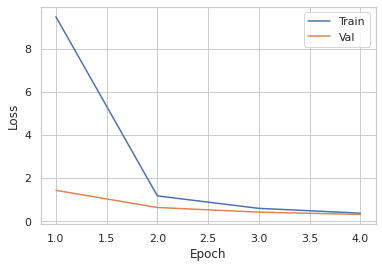

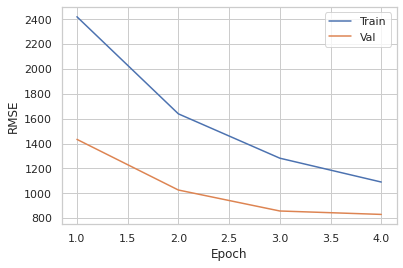

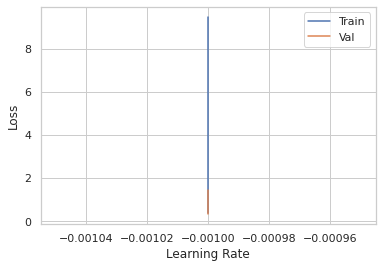

In [12]:
def plot_history(history):
    h = pd.DataFrame(history.history)
    h['epoch'] = history.epoch
    h['epoch'] = h['epoch'] + 1
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(h['epoch'], h['loss'],label='Train')
    plt.plot(h['epoch'], h['val_loss'],label='Val')
    plt.legend()
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.plot(h['epoch'], h['root_mean_squared_error'], label='Train')
    plt.plot(h['epoch'], h['val_root_mean_squared_error'], label='Val')
    plt.legend()
    plt.figure()
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.plot(h['lr']*-1, h['loss'], label='Train')
    plt.plot(h['lr']*-1, h['val_loss'], label='Val')
    plt.legend()
    plt.show()


plot_history(history)

In [13]:
model = keras.models.load_model('best_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
batch_normalization (BatchNo (None, 1536)              6144      
_________________________________________________________________
dense (Dense)                (None, 1536)              2360832   
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
output (Dense)               (None, 3)                 4611      
Total params: 13,155,122
Trainable params: 2,368,515
Non-trainable params: 10,786,607
_________________________________________________________________


In [14]:
preds = model.predict(test_gen, use_multiprocessing=False, workers=4, verbose=1)
print(f'preds.shape={preds.shape}')

1022/1022 [==============================] - 6281s 6s/step
preds.shape=(32684, 3)


In [15]:
preds = preds.T
data['fvc_last_3_cv'] = preds[0]
data['fvc_last_2_cv'] = preds[1]
data['fvc_last_1_cv'] = preds[2]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32684 entries, 0 to 32683
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pid            32684 non-null  object 
 1   age            32684 non-null  uint8  
 2   sex            32684 non-null  object 
 3   smoking        32684 non-null  object 
 4   week_1         32684 non-null  int16  
 5   fvc_1          32684 non-null  uint16 
 6   percent_1      32684 non-null  float32
 7   fvc_last_1     32684 non-null  uint16 
 8   fvc_last_2     32684 non-null  uint16 
 9   fvc_last_3     32684 non-null  uint16 
 10  week_last_1    32684 non-null  int16  
 11  week_last_2    32684 non-null  int16  
 12  week_last_3    32684 non-null  int16  
 13  img            32684 non-null  object 
 14  fvc_last_3_cv  32684 non-null  float32
 15  fvc_last_2_cv  32684 non-null  float32
 16  fvc_last_1_cv  32684 non-null  float32
dtypes: float32(4), int16(4), object(4), uint16(4), uin

In [16]:
data.head()

,pid,age,sex,smoking,week_1,fvc_1,percent_1,fvc_last_1,fvc_last_2,fvc_last_3,week_last_1,week_last_2,week_last_3,img,fvc_last_3_cv,fvc_last_2_cv,fvc_last_1_cv
0,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,ID00007637202177411956430/0.png,2163.217773,2092.664795,2106.068359
1,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,ID00007637202177411956430/1.png,2356.034912,2279.119141,2293.754395
2,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,ID00007637202177411956430/10.png,2223.280762,2150.765381,2164.610352
3,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,ID00007637202177411956430/11.png,2194.222168,2122.664795,2136.270508
4,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,ID00007637202177411956430/12.png,2264.691895,2190.799805,2204.896973


In [17]:
data.drop(['img'], axis=1, inplace=True)

In [18]:
def set_dist(row, fvc_last_1_cv, fvc_last_2_cv, fvc_last_3_cv) -> None:
    quantiles = [0, 0.5, 0.75, 0.9, 0.95, 0.99, 1]
    s = pd.Series(fvc_last_1_cv)
    qs = s.quantile(quantiles).to_numpy()
    row['fvc_last_1_min'] = qs[0]
    row['fvc_last_1_p50'] = qs[1]
    row['fvc_last_1_p75'] = qs[2]
    row['fvc_last_1_p90'] = qs[3]
    row['fvc_last_1_p95'] = qs[4]
    row['fvc_last_1_p99'] = qs[5]
    row['fvc_last_1_max'] = qs[6]
    s = pd.Series(fvc_last_2_cv)
    qs = s.quantile(quantiles).to_numpy()
    row['fvc_last_2_min'] = qs[0]
    row['fvc_last_2_p50'] = qs[1]
    row['fvc_last_2_p75'] = qs[2]
    row['fvc_last_2_p90'] = qs[3]
    row['fvc_last_2_p95'] = qs[4]
    row['fvc_last_2_p99'] = qs[5]
    row['fvc_last_2_max'] = qs[6]
    s = pd.Series(fvc_last_3_cv)
    qs = s.quantile(quantiles).to_numpy()
    row['fvc_last_3_min'] = qs[0]
    row['fvc_last_3_p50'] = qs[1]
    row['fvc_last_3_p75'] = qs[2]
    row['fvc_last_3_p90'] = qs[3]
    row['fvc_last_3_p95'] = qs[4]
    row['fvc_last_3_p99'] = qs[5]
    row['fvc_last_3_max'] = qs[6]



rows = []
row: Dict[str, Any] = {}
prev = None
fvc_last_1_cv = []
fvc_last_2_cv = []
fvc_last_3_cv = []
for t in data.itertuples():
    # new patient
    if prev is not None and prev != t.pid:
        set_dist(row, fvc_last_1_cv, fvc_last_2_cv, fvc_last_3_cv)
        rows.append(row)
    if prev is None or prev != t.pid:
        row = {}
        fvc_last_1_cv = []
        fvc_last_2_cv = []
        fvc_last_3_cv = []
        row['pid'] = t.pid
        row['age'] = t.age
        row['sex'] = t.sex
        row['smoking'] = t.smoking
        row['week_1'] = t.week_1
        row['fvc_1'] = t.fvc_1
        row['percent_1'] = t.percent_1
        row['fvc_last_1'] = t.fvc_last_1
        row['fvc_last_2'] = t.fvc_last_2
        row['fvc_last_3'] = t.fvc_last_3
        row['week_last_1'] = t.week_last_1
        row['week_last_2'] = t.week_last_2
        row['week_last_3'] = t.week_last_3
    prev = t.pid
    fvc_last_1_cv.append(t.fvc_last_1_cv)
    fvc_last_2_cv.append(t.fvc_last_2_cv)
    fvc_last_3_cv.append(t.fvc_last_3_cv)
    
# add the last patient!
if len(row) != 0:
    set_dist(row, fvc_last_1_cv, fvc_last_2_cv, fvc_last_3_cv)
    rows.append(row)


schema = {
    'pid': str,
    'age': np.uint8,
    'sex': str,
    'smoking': str,
    'week_1': np.int16,
    'fvc_1': np.uint16,
    'percent_1': np.float32,
    'fvc_last_1': np.uint16,
    'fvc_last_2': np.uint16,
    'fvc_last_3': np.uint16,
    'week_last_1': np.int16,
    'week_last_2': np.int16,
    'week_last_3': np.int16,
    'fvc_last_1_min': np.float32,
    'fvc_last_1_p50': np.float32,
    'fvc_last_1_p75': np.float32,
    'fvc_last_1_p90': np.float32,
    'fvc_last_1_p95': np.float32,
    'fvc_last_1_p99': np.float32,
    'fvc_last_1_max': np.float32,
    'fvc_last_2_min': np.float32,
    'fvc_last_2_p50': np.float32,
    'fvc_last_2_p75': np.float32,
    'fvc_last_2_p90': np.float32,
    'fvc_last_2_p95': np.float32,
    'fvc_last_2_p99': np.float32,
    'fvc_last_2_max': np.float32,
    'fvc_last_3_min': np.float32,
    'fvc_last_3_p50': np.float32,
    'fvc_last_3_p75': np.float32,
    'fvc_last_3_p90': np.float32,
    'fvc_last_3_p95': np.float32,
    'fvc_last_3_p99': np.float32,
    'fvc_last_3_max': np.float32,
}
train = pd.DataFrame.from_records(rows)
assert len(train) == 174
train = train.astype(schema)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pid             174 non-null    object 
 1   age             174 non-null    uint8  
 2   sex             174 non-null    object 
 3   smoking         174 non-null    object 
 4   week_1          174 non-null    int16  
 5   fvc_1           174 non-null    uint16 
 6   percent_1       174 non-null    float32
 7   fvc_last_1      174 non-null    uint16 
 8   fvc_last_2      174 non-null    uint16 
 9   fvc_last_3      174 non-null    uint16 
 10  week_last_1     174 non-null    int16  
 11  week_last_2     174 non-null    int16  
 12  week_last_3     174 non-null    int16  
 13  fvc_last_1_min  174 non-null    float32
 14  fvc_last_1_p50  174 non-null    float32
 15  fvc_last_1_p75  174 non-null    float32
 16  fvc_last_1_p90  174 non-null    float32
 17  fvc_last_1_p95  174 non-null    flo

In [19]:
train.head()

,pid,age,sex,smoking,week_1,fvc_1,percent_1,fvc_last_1,fvc_last_2,fvc_last_3,week_last_1,week_last_2,week_last_3,fvc_last_1_min,fvc_last_1_p50,fvc_last_1_p75,fvc_last_1_p90,fvc_last_1_p95,fvc_last_1_p99,fvc_last_1_max,fvc_last_2_min,fvc_last_2_p50,fvc_last_2_p75,fvc_last_2_p90,fvc_last_2_p95,fvc_last_2_p99,fvc_last_2_max,fvc_last_3_min,fvc_last_3_p50,fvc_last_3_p75,fvc_last_3_p90,fvc_last_3_p95,fvc_last_3_p99,fvc_last_3_max
0,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,2008.047607,2166.488525,2218.489990,2261.252197,2273.078613,2288.827148,2293.754395,1995.286133,2152.624756,2204.309814,2246.818115,2258.554932,2274.212402,2279.119141,2062.616455,2225.209473,2278.671875,2322.622559,2334.745361,2350.954346,2356.034912
1,ID00009637202177434476278,69,Male,Ex-smoker,8,3660,85.282875,3214,3390,3625,60,45,33,2018.092529,2299.831299,2350.122070,2374.165527,2386.951416,2406.859619,2438.300537,2005.254272,2285.085449,2335.061523,2358.945557,2371.639648,2391.426025,2422.645996,2072.975586,2362.251953,2413.893311,2438.608398,2451.744141,2472.179688,2504.459717
2,ID00010637202177584971671,60,Male,Ex-smoker,0,3523,94.724670,2518,2474,2993,54,37,25,2030.324951,2285.276367,2368.145996,2404.446045,2410.665771,2437.612793,2459.913086,2017.426270,2270.633545,2352.968018,2389.009766,2395.194336,2421.962158,2444.112305,2085.491211,2347.295410,2432.350098,2469.629883,2475.991211,2503.668701,2526.614990
3,ID00012637202177665765362,65,Male,Never smoked,33,3418,93.726006,2971,3231,3324,87,71,58,1957.703491,2267.683594,2412.646973,2424.831299,2439.296387,2471.139893,2472.631348,1945.258423,2253.208008,2397.190918,2409.274414,2423.660645,2455.282715,2456.767578,2010.960083,2329.215088,2478.108398,2490.584961,2505.481201,2538.166016,2539.718018
4,ID00014637202177757139317,56,Male,Ex-smoker,0,3807,90.076660,3027,3439,3221,54,37,26,2009.789429,2240.865234,2360.055176,2396.740723,2410.666992,2434.207520,2439.552979,1997.049194,2226.604980,2345.000732,2381.401123,2395.281006,2418.658203,2423.964844,2064.418457,2301.737061,2424.079102,2461.700684,2476.105469,2500.291260,2505.783203


In [20]:
train.to_parquet('output/cvtrain.parquet', index=False)